# Main Notebook: NLP Series Workshop 2: Diving Deeper into NLP Classification Problems

Credit to this wonderful notebook which we used as a basis for this workshop: https://www.kaggle.com/code/dorgavra/emotion-classification-nlp/notebook

<span style="color:red">__DISCLAIMER__</span> : This dataset contains hateful speech and explicit content. 

Conventions used:

❗ - Required <br>
❓ - Question <br>

## 1. Setup and Exploration

### a. Setup

The dataset we'll use can be found here: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [ ]:
import gdown
!mkdir -p /content/emotion-sentiment
%cd /content/emotion-sentiment
gdown.download('https://drive.google.com/uc?export=download&id=1EFpJf3GblKvBzutrykHZvoBVPdqFrTh_')
!unzip -q archive.zip
!rm archive.zip

/content/emotion-sentiment


Downloading...
From: https://drive.google.com/uc?export=download&id=1EFpJf3GblKvBzutrykHZvoBVPdqFrTh_
To: /content/emotion-sentiment/archive.zip
100%|██████████| 738k/738k [00:00<00:00, 74.0MB/s]


__BACKUP CELL__: If (*and only if*) you are unable to download with the above cell:
1. [download the dataset](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)
2. uncomment and run the cell below
3. upload archive.zip (make sure this is the exact name!)

In [ ]:
# from google.colab import files
# !mkdir -p /content/emotion-sentiment
# %cd /content/emotion-sentiment
# files.upload() # upload archive.zip

Import Libraries

In [ ]:
import re
import nltk
import numpy as np
import pandas as pd

from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras.backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import Sequential
from keras.layers import Dense, SimpleRNN, Embedding, Flatten, Dropout

Load Datasets with Pandas

In [ ]:
test_data = pd.read_csv("/content/emotion-sentiment/test.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
train_data = pd.read_csv("/content/emotion-sentiment/train.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")
validation_data = pd.read_csv("/content/emotion-sentiment/val.txt", header=None, sep=";", names=["Comment","Emotion"], encoding="utf-8")

### b. Exploration

The creator of this Kaggle dataset split the data into 3 parts: train (for training our model), validation (for checking how well our model performs), and test (for seeing how our model performs on wild data).

Let's examine our Train, Validation, and Test data. First, we'll look at size.

In [ ]:
print("Train size:\t", train_data.shape)
print("Test size:\t", test_data.shape)
print("Validation:\t", validation_data.shape)

Train size:	 (16000, 2)
Test size:	 (2000, 2)
Validation:	 (2000, 2)


Let's now look at the contents of our train data:

In [ ]:
train_data

,Comment,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


1. We have a "comment", which is a sentence indicating someone's emotional state.
  - This seems like the natural language data our model will read.
2. We have a corresponding "emotion" label which categorizes the emotion.
  - This seems like the labels our model will learn to attribute to setences.


We now find all "emotion" labels in our data:

In [ ]:
print(train_data['Emotion'].unique())

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


We have 6 "emotion" classes; so, we'll be training a model for *multi-class classification*.

❓: What is __multi-class classification__?

> __multi-class classification__ : classifying instances into more than two classes

## 2. Preprocessing

### a. Dataset Modifications

First, we'll add a column names "Length" to the `train_data` table which will hold the length of each sentence.

In [ ]:
train_data['Length'] = [len(x) for x in train_data['Comment']]

Second, we're going to replace the emotion names with integers.

So, 'sadness', 'anger', 'love', 'surprise', 'fear', and 'joy' will be replaced with integers from 0 to 5. We will use sk-learn's `LabelEncoder()` class to do this.

In [ ]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])
test_data['Emotion'] = lb.fit_transform(test_data['Emotion'])
validation_data['Emotion'] = lb.fit_transform(validation_data['Emotion'])

Now let's take a look at the modified `train_data` table.

In [ ]:
train_data

,Comment,Emotion,Length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


### b. Data Cleaning

Now, let's clean our text data. Generally speaking, we want to

1. remove excess and unneccessary info from our data, and
2. make the data readable by a computer.

There are many ways to do this, but we will cover stop words, stemming, and one-hot encoding.

#### i. Stop Words

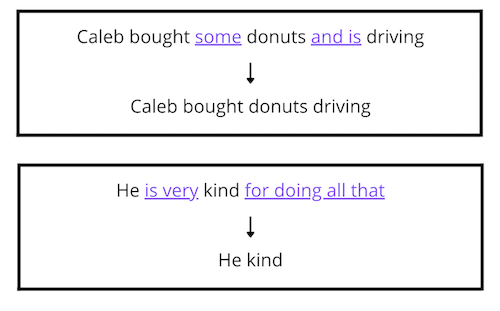

We will use the nltk (natural language tool kit) stop word list.

In [ ]:
sentences = ['Caleb bought some donuts and is driving', 'He is very kind for doing all that']

nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))
print()

for sentence in sentences:
  stopped = " ".join([word for word in sentence.split() if word not in stopwords])
  print(f"{sentence}\n{stopped}\n")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Caleb bought some donuts and is driving
Caleb bought donuts driving

He is very kind for doing all that
He kind



#### ii. Stemming

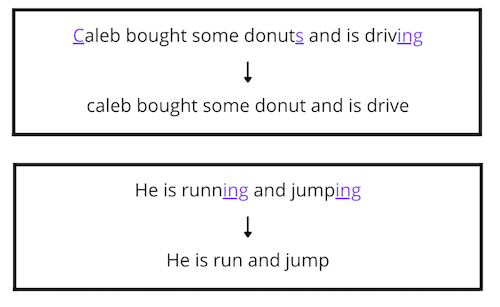

We will use nltk's function `PorterStemmer()` to handle stemming.

In [ ]:
sentences = ['Caleb bought some donuts and is driving', 'He is running and jumping']

stemmer = PorterStemmer()

for sentence in sentences:
  stemmed = " ".join([stemmer.stem(word) for word in sentence.split()])
  print(f"{sentence}\n{stemmed}\n")

Caleb bought some donuts and is driving
caleb bought some donut and is drive

He is running and jumping
He is run and jump



#### iii. One-Hot Encoding

TensorFlow Keras has a function, `one_hot()`, which functions in the below manner.

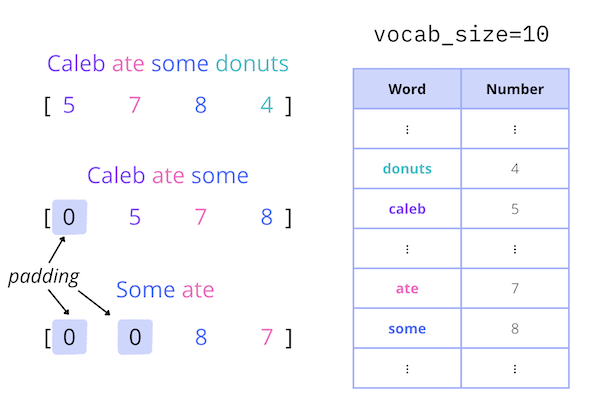

Let's test implementing TensorFlow Keras's `one_hot()` function.

In [ ]:
sentences = ['Caleb ate some donuts', 'Caleb ate some', 'Some ate Caleb']

max_len = max([len(sentence.split()) for sentence in sentences])

encoded = []
for sentence in sentences:
  encoded.append(one_hot(input_text=sentence, n=20))

padded = pad_sequences(sequences=encoded,maxlen=max_len,padding='pre')

for i in range(3): print(f"{sentences[i]}\n{padded[i]}\n")

Caleb ate some donuts
[ 1 10 17 14]

Caleb ate some
[ 0  1 10 17]

Some ate Caleb
[ 0 17 10  1]



We will incorporate the above techniques into a function `text_cleaning()`

This function is really complex, so we won't cover every single little detail. At a high level, we:
1. remove special characters
2. convert everything to lowercase
3. remove stop words
4. stem our data
5. apply one-hot encoding

In the end, we are just trying to convert the data (both the tweets and the labels) into a format acceptable for training the model. This is the essence of __preprocessing__.

In [ ]:
vocab_size = 11000                  # decide that vocab length will be 11000
max_len=train_data['Length'].max()  # get max length of a word

# we will download our stopwords from nltk
nltk.download('stopwords')
stopwords = set(nltk.corpus.stopwords.words('english'))

def text_cleaning(df, column):

  """Removing unrelevent chars, Stemming and padding"""
  stemmer = PorterStemmer()
  corpus = []
  
  for text in df[column]:
    # convert to lower case and remove special chars
    text = text_to_word_sequence(text)

    # apply stemming and remove stop words
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)

    corpus.append(text)

  # one-hot encode each sentence; converts each sentence to a vector
  one_hot_word = [one_hot(input_text=sentence, n=vocab_size) for sentence in corpus]
  # makes all vectors the same length
  pad = pad_sequences(sequences=one_hot_word,maxlen=max_len,padding='pre')

  return pad

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now that we have our `text_cleaning()` function, we can apply it to our train, validation, and test data.

In [ ]:
x_train = text_cleaning(train_data, "Comment")
x_val = text_cleaning(validation_data, "Comment")
x_test = text_cleaning(test_data, "Comment")

In [ ]:
print(x_train)
print(x_train.shape)

[[    0     0     0 ...  8634  1997  4527]
 [    0     0     0 ...  7148  1188  5095]
 [    0     0     0 ...  1997  6397  4042]
 ...
 [    0     0     0 ...  6020  7751  2240]
 [    0     0     0 ...  9878  3261 10534]
 [    0     0     0 ...  1997  2845 10329]]
(16000, 300)


`x_train` is a collection of vectors; each vector represents a sentence in our train dataset.


`x_train` has 16000 vectors, while `x_test` and `x_val` have 2000 vectors each.

Now we create `y_train`, `y_val`, and `y_test` out of the emotion labels.

In [ ]:
y_train_nums = train_data["Emotion"]
y_val_nums = validation_data["Emotion"]
y_test_nums = test_data["Emotion"]

y_train = to_categorical(y_train_nums)
y_val = to_categorical(y_val_nums)
y_test = to_categorical(y_test_nums)

print("As Numbers:\n" + str(y_train_nums.head(5)))
print()
print("As Vectors:\n" + str(y_train[0:5]))

As Numbers:
0    4
1    4
2    0
3    3
4    0
Name: Emotion, dtype: int64

As Vectors:
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


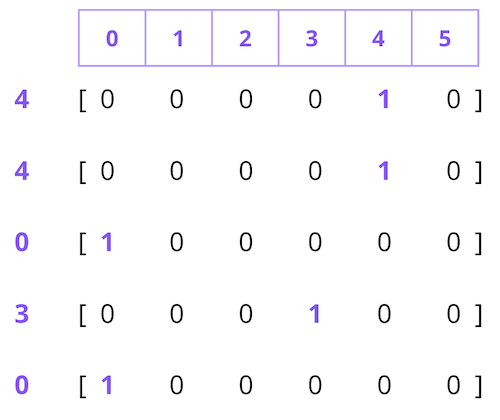

`to_categorial()` applies a more traditional form of one-hot encoding to convert all "emotion" label values to vector represenations.

In [ ]:
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(16000, 6)
(2000, 6)
(2000, 6)


`y_train` has 16000 vectors, while `y_test` and `y_val` have 2000 vectors each.

We now have cleaned data, split across `x_train`, `x_test`, and `x_val`, along with our labels in `y_train`, `y_val`, and `y_test`. We are ready to begin making our model!

## 3. Modeling RNN

A standard neural net, known as a "forward-pass" neural net, looks at input data in an isolated environment. In other words, when training on a piece of data, it does not remember prior pieces of data.

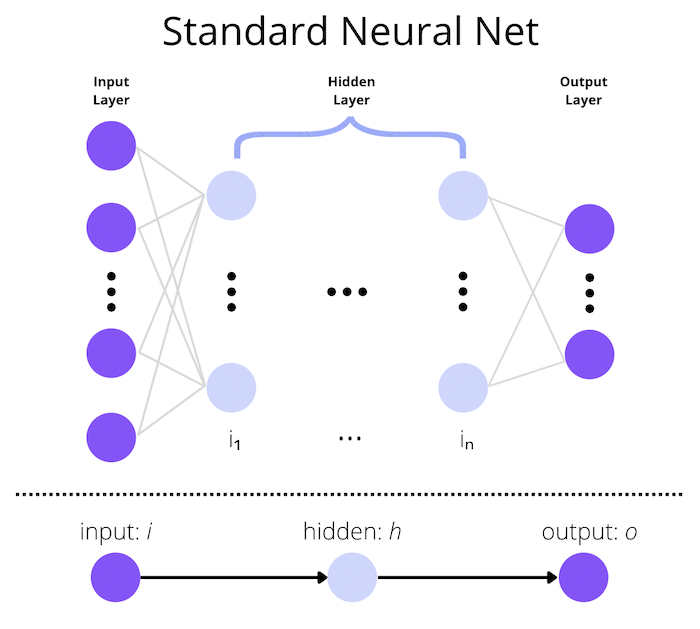

❓: What is __Sequential Data__?

> __Sequential Data__ : a dataset where data points rely on other data points

For example, sentences are a form of *sequential data*; each word's meaning depends on the other words in the sentence for context. A forward-pass neural net is not good for handling sequential data.

❓: What is __Recurrent Neural Network (RNN)__?

> __Recurrent Neural Network (RNN)__ : An RNN is a special type of neural network built to process sequential data; it is a model with its own internal memory

RNNs processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

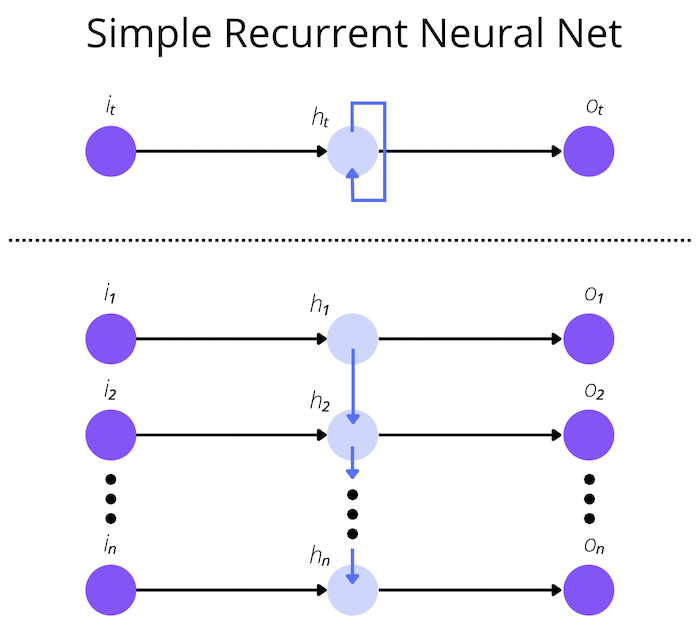

RNNs are great for NLP purposes because they can analyze each word in the context of previous words, thereby deriving more meaning from a sentence!

The following code creates the model and adds layers to it.

❓ What do each of the layers do at a high level?

Here are the layers we will be using:
1. `Embedding`: maps our input to a latent space smaller than our vocab
2. `Dropout`: zeros out some neurons to avoid overfitting
3. `SimpleRNN`: a simple RNN model similar in makeup to the above figure
4. `Dense`: a layer of neurons which outputs a tensor of specified size

For example, we end our model with a Dense layer `Dense(6,activation='softmax')`. This layer outputs a tensor of dimension 6 (since we have 6 empotion classeS) using a softmax activation function (since softmax is an extension of sigmoud which handles multple output classes). You can read more on softmax here: https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax

In [ ]:
def build_model():
  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, input_length=max_len, output_dim=150))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(128))
  model.add(Dropout(0.2))
  model.add(Dense(64,activation='sigmoid'))
  model.add(Dropout(0.2))
  model.add(Dense(6,activation='softmax'))

  model.compile(optimizer='Adam', loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy', 
                                                                       tf.keras.metrics.Precision(), 
                                                                       tf.keras.metrics.Recall()])

  return model

## 4. Training

Now we can get started on training! First, we'll use our function `build_model()` to create our model.

In [ ]:
model = build_model()

Now, we'll go ahead and train our model using `fit()`.

- **x_train:** training text <br>
- **y_train:** labels (emotion) of the training text <br>
- **epochs:** number of times the model will go through the dataset <br>
- **batch_size:** number of training samples that go through the model 

In [ ]:
hist = model.fit(x_train,y_train,epochs=10,batch_size=64,
                 validation_data=(x_val,y_val), verbose=1)

Epoch 1/10
250/250 [==============================] - 55s 202ms/step - loss: 1.5896 - accuracy: 0.3633 - precision: 0.4973 - recall: 0.0400 - val_loss: 1.3772 - val_accuracy: 0.5265 - val_precision: 0.7238 - val_recall: 0.2555
Epoch 2/10
250/250 [==============================] - 51s 205ms/step - loss: 1.1703 - accuracy: 0.5924 - precision: 0.7064 - recall: 0.4631 - val_loss: 1.0041 - val_accuracy: 0.6680 - val_precision: 0.7514 - val_recall: 0.5245
Epoch 3/10
250/250 [==============================] - 50s 200ms/step - loss: 0.8918 - accuracy: 0.6801 - precision: 0.7742 - recall: 0.5767 - val_loss: 1.0101 - val_accuracy: 0.6315 - val_precision: 0.7481 - val_recall: 0.5375
Epoch 4/10
250/250 [==============================] - 50s 200ms/step - loss: 0.7781 - accuracy: 0.7162 - precision: 0.7971 - recall: 0.6261 - val_loss: 0.7992 - val_accuracy: 0.7110 - val_precision: 0.7834 - val_recall: 0.6240
Epoch 5/10
250/250 [==============================] - 50s 200ms/step - loss: 0.6241 - accura

Now, let's evaulate our model on the validation and test data!

In [ ]:
print("Validation: ")
model.evaluate(x_val,y_val,verbose=1)
print("\nTest: ")
model.evaluate(x_test,y_test,verbose=1)
print()

Validation: 
63/63 [==============================] - 1s 24ms/step - loss: 0.6062 - accuracy: 0.8205 - precision: 0.8295 - recall: 0.8075

Test: 
63/63 [==============================] - 2s 24ms/step - loss: 0.6456 - accuracy: 0.8120 - precision: 0.8203 - recall: 0.8055



## 5. Conclusion

There is certainly room for improvement, though. This can be acheived through:

1. different preprocessing techniques
2. adjusted RNN model setup (different kinds of RNNs, different layers, etc)
3. training for longer/differently (more epochs, smaller batch size)